In [1]:
import numpy as np 
import torch

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
import matplotlib.image as mpimg


from torchvision import transforms, models
import torch.optim as optim

In [2]:
vgg = models.vgg19(pretrained=True).features

In [3]:
# freeze vgg parameters since we are only optimizing the target

for param in vgg.parameters():
    param.requires_grad_(False)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# passing the model to cuda
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [6]:
content = Image.open('deep-learning-v2-pytorch/style-transfer/images/octopus.jpg')
style = Image.open('deep-learning-v2-pytorch/style-transfer/images/hockney.jpg')

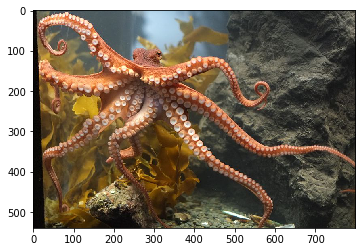

In [7]:
plt.imshow(content)

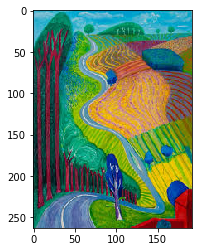

In [8]:
plt.imshow(style)

In [9]:
style.size

(192, 263)

In [10]:
content.size

(800, 540)

In [11]:
transform = transforms.Compose([transforms.Resize(content.size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])

In [12]:
content_image = transform(content)

In [13]:
style_image = transform(style)

In [14]:
content_image.shape

torch.Size([3, 800, 540])

In [15]:
style_image.shape

torch.Size([3, 800, 540])

In [16]:
# CNN expects a tensor with the shape (batch_size, d, w, h)
style_image = style_image.unsqueeze(0)

In [17]:
style_image.shape

torch.Size([1, 3, 800, 540])

In [18]:
content_image = style_image.unsqueeze(0)

In [19]:
# 
def load_image(img_path, size=(400, 592)):
    
    image = Image.open(img_path)
    
    transform = transforms.Compose([transforms.Resize(size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])
    
    image = transform(image).unsqueeze(0)
    
    return image

In [20]:
def im_convert(tensor):
    
    image = tensor.to('cpu').clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image*np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0,1)
    
    return image

In [21]:
content = load_image('deep-learning-v2-pytorch/style-transfer/images/octopus.jpg').to(device)
style = load_image('deep-learning-v2-pytorch/style-transfer/images/hockney.jpg').to(device)

In [22]:
content.shape

torch.Size([1, 3, 400, 592])

In [23]:
style.shape

torch.Size([1, 3, 400, 592])

In [24]:
style.shape

torch.Size([1, 3, 400, 592])

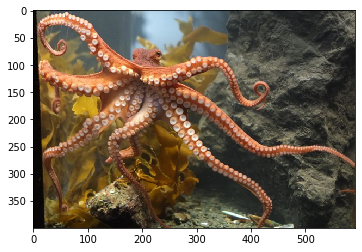

In [25]:
plt.imshow(im_convert(content))

In [26]:
layers = {'0': 'conv1_1',
         '5': 'conv2_1',
         '10': 'conv3_1',
         '19': 'conv4_1',
         '21': 'conv4_2',
         '28': 'conv5_1'}

In [27]:
# getting the features from the vgg model
# from the paper, the content rep is conv4_2
# style rep is: conv1_1, conv2_1, conv3_1, conv4_1, conv5_1

def get_features (image, model):

    features = {}

    for key, layer in vgg._modules.items():
        image = layer(image)
        if key in layers:
            features[layers[key]] = image
                
    return features

In [28]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [29]:
# getting the style representation
# this function gets the output of a CNN (tensor)
# returns the gram matrix

def gram_matrix(tensor):
    
    batch_size, d, h, w = tensor.size()
    
    tensor = tensor.view(d, h*w)
    
    gram = torch.mm(tensor, tensor.t())
    
    return gram

In [30]:
# calc the style representation for each layer 

style_grams = {}

for layer, tensor in style_features.items():
    gram = gram_matrix(tensor)
    style_grams[layer] = gram

In [31]:
# creating a target image

target = content.clone().requires_grad_(True).to(device)

In [32]:
style_grams.keys()

dict_keys(['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv4_2', 'conv5_1'])

In [33]:
# Defining the weights

style_weights = {'conv1_1': 1,
                 'conv2_1' : 0.75, 
                 'conv3_1': 0.2, 
                 'conv4_1': 0.2, 
                 'conv5_1' : 0.2}

content_weight = 1
style_weight = 1e6

Total loss:  tensor(1154031.1250, device='cuda:0', grad_fn=<AddBackward0>)


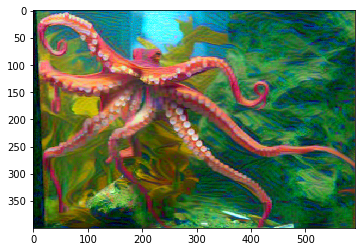

Total loss:  tensor(356679.2500, device='cuda:0', grad_fn=<AddBackward0>)


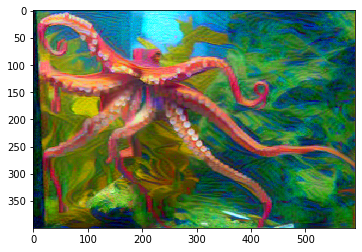

Total loss:  tensor(191081.8125, device='cuda:0', grad_fn=<AddBackward0>)


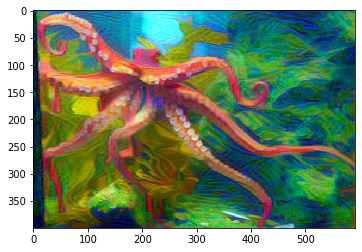

Total loss:  tensor(113131.9375, device='cuda:0', grad_fn=<AddBackward0>)


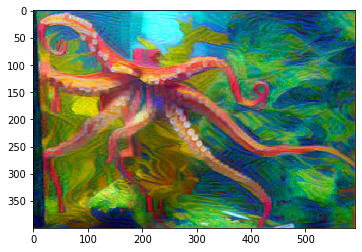

In [34]:
# updating the target and calculating the losses

show_every = 500
steps = 2000

optimizer = optim.Adam([target], lr=0.003)

for i in range(1, steps+1):
    
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape
        
        target_gram = gram_matrix(target_feature)
        
        style_gram = style_grams[layer]
        
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        
        style_loss += layer_style_loss/ (d*h*w)
        

    total_loss = content_weight * content_loss + style_weight * style_loss
    
    
    # updating the target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if i % show_every == 0:
        print('Total loss: ', total_loss)
        plt.imshow(im_convert(target))
        plt.show()